In [ ]:
!pip install pykalman

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.4/249.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.5/149.5 kB 9.4 MB/s eta 0:00:00


In [ ]:
pip install yfinance pandas numpy matplotlib seaborn scikit-learn tensorflow keras hmmlearn statsmodels ta transformers torch tqdm


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 3.4 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=ca94988c61bbd49ba91a3985eff63a5701c5783b55954bf08662e01f9be27cd7
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator, EMAIndicator
from pykalman import KalmanFilter
from hmmlearn.hmm import GaussianHMM
from sklearn.mixture import BayesianGaussianMixture
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import warnings
warnings.filterwarnings("ignore")


[*********************100%***********************]  1 of 1 completed


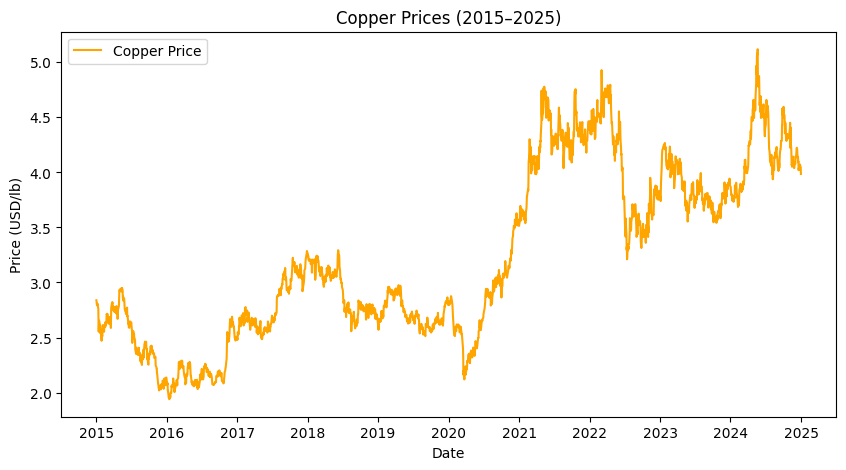

Price,COPPER
Ticker,HG=F
Date,
2015-01-02,2.8385
2015-01-05,2.7930
2015-01-06,2.8040
2015-01-07,2.7960
2015-01-08,2.8070


In [ ]:
# --- Load Copper Prices ---
df = yf.download("HG=F", start="2015-01-01", end="2025-01-01")  # COMEX Copper Futures
df = df[["Close"]].rename(columns={"Close": "COPPER"})
df.dropna(inplace=True)

plt.figure(figsize=(10,5))
plt.plot(df["COPPER"], label="Copper Price", color='orange')
plt.title("Copper Prices (2015–2025)")
plt.xlabel("Date")
plt.ylabel("Price (USD/lb)")
plt.legend()
plt.show()

df.head()


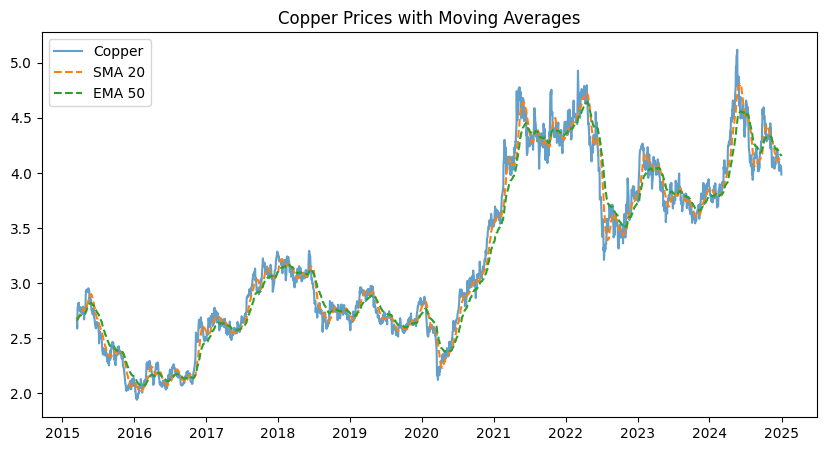

Price,COPPER,RSI,MACD,Signal_Line,SMA_20,EMA_50
Ticker,HG=F,,,,,
Date,,,,,,
2024-12-24,4.0495,40.609984,-0.037343,-0.028964,4.114875,4.172974
2024-12-26,4.0720,43.587743,-0.036000,-0.030371,4.116525,4.169014
2024-12-27,4.0625,42.616167,-0.035296,-0.031356,4.116300,4.164837
2024-12-30,4.0455,40.860935,-0.035698,-0.032225,4.114550,4.160157
2024-12-31,3.9860,35.370058,-0.040353,-0.033850,4.110075,4.153328


In [ ]:
# --- 4. Technical Indicators (RSI, MACD, SMA, EMA) ---

# Ensure the 'COPPER' column is a 1-D Series
copper_series = pd.Series(np.ravel(df["COPPER"].values), index=df.index)

# RSI
df["RSI"] = RSIIndicator(close=copper_series, window=14).rsi()

# MACD
macd_obj = MACD(close=copper_series)
df["MACD"] = pd.Series(np.ravel(macd_obj.macd().values), index=df.index)
df["Signal_Line"] = pd.Series(np.ravel(macd_obj.macd_signal().values), index=df.index)

# Moving Averages
df["SMA_20"] = SMAIndicator(close=copper_series, window=20).sma_indicator()
df["EMA_50"] = EMAIndicator(close=copper_series, window=50).ema_indicator()

# Clean up
df.dropna(inplace=True)

# Plot
plt.figure(figsize=(10,5))
plt.plot(df["COPPER"], label="Copper", alpha=0.7)
plt.plot(df["SMA_20"], label="SMA 20", linestyle="--")
plt.plot(df["EMA_50"], label="EMA 50", linestyle="--")
plt.title("Copper Prices with Moving Averages")
plt.legend()
plt.show()

df.tail()


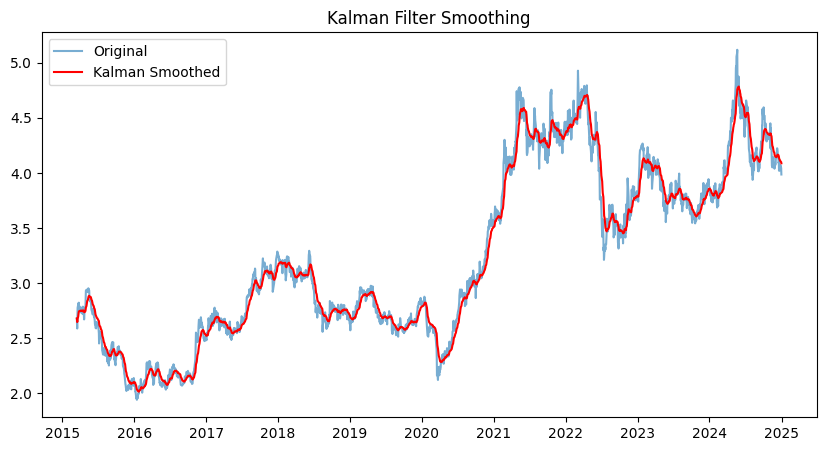

In [ ]:
# --- Kalman Filter Smoothing ---
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=df["COPPER"].values[0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

state_means, _ = kf.filter(df["COPPER"].values)
df["Kalman_Smoothed"] = state_means

plt.figure(figsize=(10,5))
plt.plot(df["COPPER"], label="Original", alpha=0.6)
plt.plot(df["Kalman_Smoothed"], label="Kalman Smoothed", color='red')
plt.legend()
plt.title("Kalman Filter Smoothing")
plt.show()


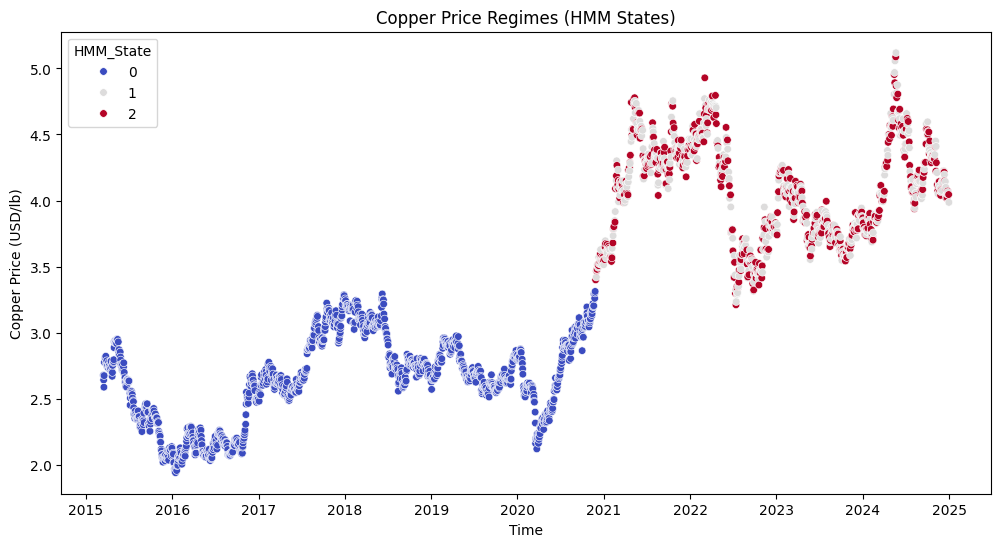

In [ ]:
# --- 6. Hidden Markov Model (HMM) ---

# Ensure the copper data is 1-D for fitting and plotting
copper_vals = np.ravel(df["COPPER"].values)

# Fit the model
hmm = GaussianHMM(n_components=3, covariance_type="diag", n_iter=200)
hmm.fit(copper_vals.reshape(-1, 1))
hidden_states = hmm.predict(copper_vals.reshape(-1, 1))

# Store in DataFrame
df["HMM_State"] = hidden_states

# Plot — make sure everything passed to seaborn is 1-D
plt.figure(figsize=(12,6))
sns.scatterplot(
    x=df.index,
    y=np.ravel(df["COPPER"].values),
    hue=df["HMM_State"],
    palette="coolwarm",
    s=30
)
plt.title("Copper Price Regimes (HMM States)")
plt.xlabel("Time")
plt.ylabel("Copper Price (USD/lb)")
plt.show()


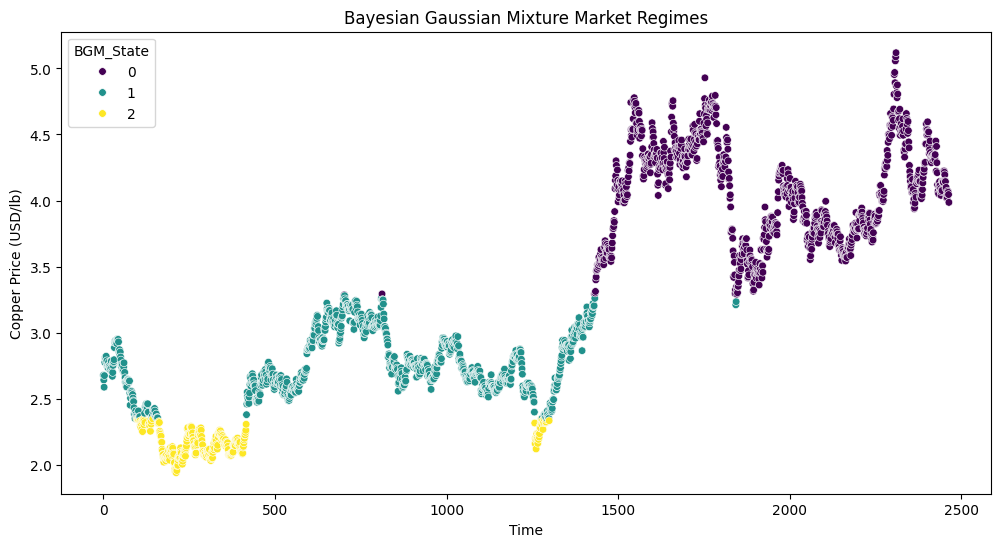

In [ ]:
# --- 7. Bayesian Gaussian Mixture (BGM) ---

# Make sure copper prices are strictly 1-D
copper_vals = np.ravel(df["COPPER"].values)

# Fit Bayesian Gaussian Mixture model
bgm = BayesianGaussianMixture(n_components=3, covariance_type="diag", n_init=5)
bgm.fit(copper_vals.reshape(-1, 1))
bgm_states = bgm.predict(copper_vals.reshape(-1, 1))

# Store the states in DataFrame
df["BGM_State"] = bgm_states

# Plot regimes — ensure all arrays are 1-D
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=np.arange(len(copper_vals)),
    y=copper_vals,
    hue=df["BGM_State"].astype(int),
    palette="viridis",
    s=30
)
plt.title("Bayesian Gaussian Mixture Market Regimes")
plt.xlabel("Time")
plt.ylabel("Copper Price (USD/lb)")
plt.show()


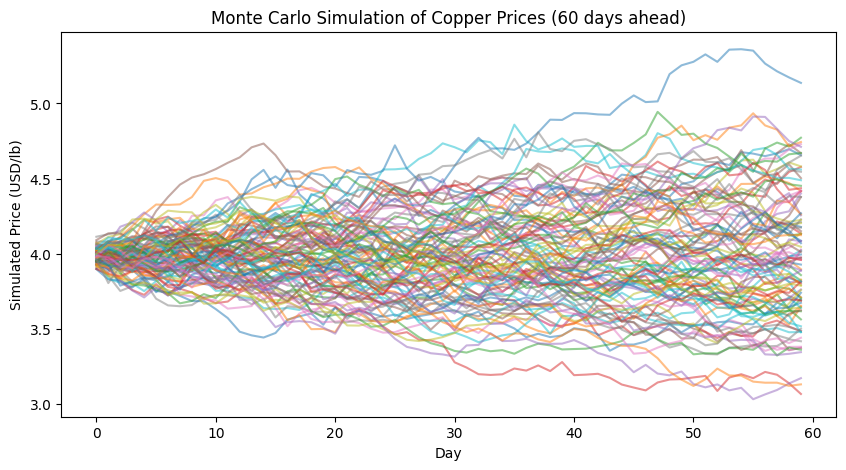

In [ ]:
# --- 8. Monte Carlo Simulation for Copper Prices ---

import numpy as np
import matplotlib.pyplot as plt

# Extract and clean copper prices
copper_prices = df["COPPER"].values.flatten()

# Calculate daily log returns
log_returns = np.diff(np.log(copper_prices))
mu = np.mean(log_returns)
sigma = np.std(log_returns)

# Simulation parameters
n_simulations = 100     # number of simulated paths
n_days = 60             # days to simulate

# Initialize matrix for simulations
simulations = np.zeros((n_days, n_simulations))

# Run simulations
for sim in range(n_simulations):
    price_series = [copper_prices[-1]]  # start from last known price
    for day in range(1, n_days + 1):
        # geometric Brownian motion formula
        price = price_series[-1] * np.exp((mu - 0.5 * sigma**2) + sigma * np.random.normal())
        price_series.append(price)
    # Ensure conversion to numpy array for assignment
    simulations[:, sim] = np.array(price_series[1:])

# Plot all simulated paths
plt.figure(figsize=(10, 5))
plt.plot(simulations, alpha=0.5)
plt.title("Monte Carlo Simulation of Copper Prices (60 days ahead)")
plt.xlabel("Day")
plt.ylabel("Simulated Price (USD/lb)")
plt.show()


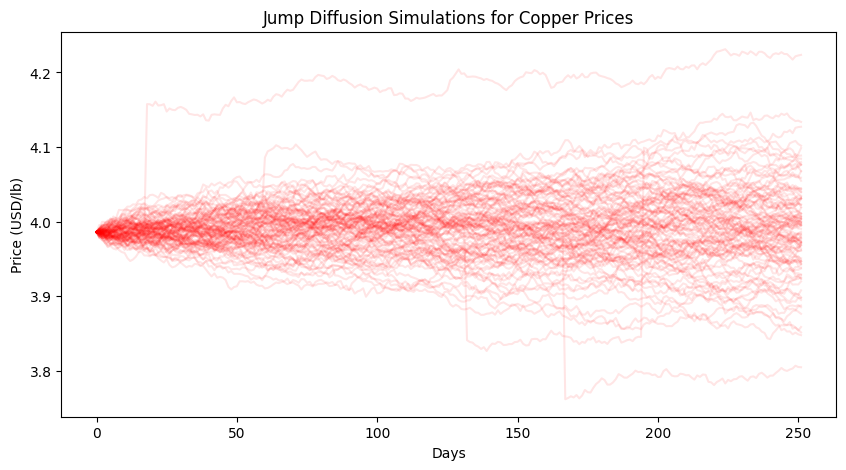

In [ ]:
# --- Jump Diffusion Model ---
mu = df["COPPER"].pct_change().mean()
sigma = df["COPPER"].pct_change().std()
S0 = df["COPPER"].iloc[-1]
jd_prices = jump_diffusion_sim(S0, mu, sigma, lamb=0.1, mu_j=-0.02, sigma_j=0.05)

def jump_diffusion_sim(S0, mu, sigma, lamb, mu_j, sigma_j, T=1, steps=252, n_sims=100):
    dt = T/steps
    prices = np.zeros((steps, n_sims))
    for sim in range(n_sims):
        prices[0, sim] = S0
        for t in range(1, steps):
            N = np.random.poisson(lamb * dt)
            J = np.sum(np.random.normal(mu_j, sigma_j, N))
            drift = (mu - 0.5 * sigma**2) * dt
            diffusion = sigma * np.sqrt(dt) * np.random.normal()
            prices[t, sim] = prices[t-1, sim] * np.exp(drift + diffusion + J)
    return prices

jd_prices = jump_diffusion_sim(S0, mu, sigma, lamb=0.1, mu_j=-0.02, sigma_j=0.05)
plt.figure(figsize=(10,5))
plt.plot(jd_prices, alpha=0.1, color='red')
plt.title("Jump Diffusion Simulations for Copper Prices")
plt.xlabel("Days")
plt.ylabel("Price (USD/lb)")
plt.show()


In [ ]:
# --- FinBERT Sentiment Analysis ---
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

headlines = [
    "Copper prices rally as China boosts industrial demand",
    "Concerns rise over declining copper exports",
    "Global slowdown weighs on copper demand",
]

def get_finbert_sentiment(texts):
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    labels = torch.argmax(probs, dim=1)
    sentiment_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
    return [sentiment_map[i.item()] for i in labels]

sentiments = get_finbert_sentiment(headlines)
for h, s in zip(headlines, sentiments):
    print(f"{h} → {s}")


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Copper prices rally as China boosts industrial demand → Neutral
Concerns rise over declining copper exports → Positive
Global slowdown weighs on copper demand → Positive


Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - loss: 0.0352 - val_loss: 0.0046
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0030 - val_loss: 0.0054
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - loss: 0.0021 - val_loss: 0.0041
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0032 - val_loss: 0.0131
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 0.0030 - val_loss: 0.0040
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - loss: 0.0014 - val_loss: 0.0078
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - loss: 0.0013 - val_loss: 0.0054
Epoch 9/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - loss: 0.0017 - val_loss: 0.0037
Epoch 10/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 11/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 12/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/s

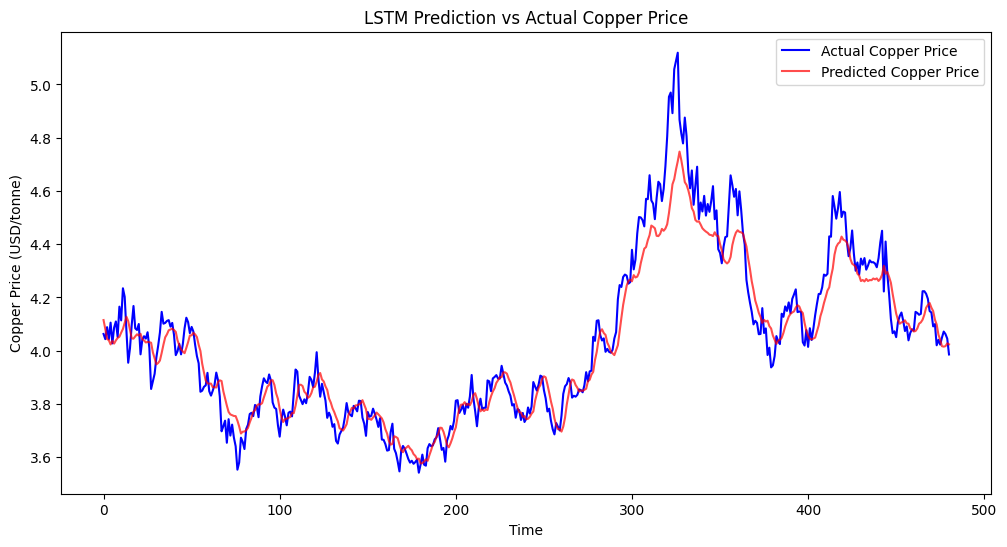

RMSE: 0.0922


In [ ]:
# --- 9. LSTM Training and Copper Price Prediction ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# --- Prepare Data ---

# Select numerical columns (excluding date if any)
features = df.select_dtypes(include=[np.number]).copy()

# Choose your target column here
target_col = "COPPER"  # <-- change to "SILVER" later if needed

if target_col not in features.columns:
    raise ValueError(f"{target_col} column not found in dataframe. Available columns: {list(features.columns)}")

# Fill NaN values
features = features.fillna(method='ffill').fillna(method='bfill')

# Scale features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

# Create sequences for LSTM
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i, features.columns.get_loc(target_col)])
    return np.array(X), np.array(y)

seq_len = 60
X, y = create_sequences(scaled_data, seq_len)

# Split into train/test (80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Build LSTM Model ---

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

# --- Make Predictions ---
y_pred = model.predict(X_test)

# Inverse transform predictions & actuals to original scale
scaler_for_target = MinMaxScaler()
scaler_for_target.fit(features[[target_col]])
y_test_rescaled = scaler_for_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler_for_target.inverse_transform(y_pred)

# --- Plot Predicted vs Actual ---
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Copper Price', color='blue')
plt.plot(y_pred_rescaled, label='Predicted Copper Price', color='red', alpha=0.7)
plt.title("LSTM Prediction vs Actual Copper Price")
plt.xlabel("Time")
plt.ylabel("Copper Price (USD/tonne)")
plt.legend()
plt.show()

# --- RMSE ---
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"RMSE: {rmse:.4f}")
from sklearn.metrics import r2_score

# Calculate R²
#r2 = r2_score(y_test, predicted_prices)
#print(f"R² Score: {r2:.4f}")


In [ ]:
# --- Model Evaluation Metrics ---

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Try to detect prediction variable
try:
    y_pred_eval = predicted_prices
except NameError:
    try:
        y_pred_eval = predictions
    except NameError:
        try:
            y_pred_eval = y_pred
        except NameError:
            raise NameError("Couldn't find prediction variable. Make sure your LSTM cell outputs predictions.")

# Ensure both y_test and predictions are 1D arrays
y_test = np.array(y_test).flatten()
y_pred_eval = np.array(y_pred_eval).flatten()

# Calculate metrics
r2 = r2_score(y_test, y_pred_eval)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_eval))
mae = mean_absolute_error(y_test, y_pred_eval)

# Print results
print("📊 Model Performance Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


📊 Model Performance Metrics:
R² Score: 0.9138
RMSE: 0.0290
MAE: 0.0209
